In [1]:
from glob import glob
import numpy as np
from sklearn.model_selection import train_test_split
import cv2
import torch
import torch.nn as nn
import torch.nn.functional
import torchvision
from torch.utils.data import TensorDataset, Dataset
import math
import os

In [ ]:
import os
from PIL import Image
import numpy as np
import torch
from torch.utils.data import Dataset

class Synapse_dataset(Dataset):
    def __init__(self, data_root, label_root, transform=None, output_size=(224, 224)):
        self.data_root = data_root
        self.label_root = label_root
        self.transform = transform
        self.output_size = output_size
        self.img_extensions = ('.png',)
        
        self.image_paths = []
        self.label_paths = []
        for f in os.listdir(data_root):
            if f.lower().endswith(self.img_extensions):
                self.image_paths.append(os.path.join(data_root, f))
        for f in os.listdir(label_root):
            if f.lower().endswith(self.img_extensions):
                self.label_paths.append(os.path.join(label_root, f))
        self.image_paths.sort()
        self.label_paths.sort()
        
        assert len(self.image_paths) == len(self.label_paths), "Number of images and labels must match!"
    def __len__(self):
        return len(self.image_paths)
    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('L')
        label = Image.open(self.label_paths[idx]).convert('L')
        if (image.width, image.height) != self.output_size:
            image = image.resize(self.output_size, Image.BICUBIC)
            label = label.resize(self.output_size, Image.NEAREST)
        image_array = np.array(image, dtype=np.float32) / 255.0
        label_array = (np.array(label) > 0).astype(np.int64)
        sample = {'image': image_array, 'label': label_array}
        if self.transform:
            sample = self.transform(sample)
        else:
            sample = {
                'image': torch.from_numpy(image_array).unsqueeze(0),
                'label': torch.from_numpy(label_array)
            }
        return sample

## Dataset loader

In [3]:
BATCH_SIZE = 12
train = Synapse_dataset(data_root = "/kaggle/input/training-data-for-lung-canceraugmented/augmented_scans" , label_root = "/kaggle/input/training-data-for-lung-canceraugmented/augmented_masks")
valid = Synapse_dataset(data_root = "/kaggle/input/lung2data/valid_2/origin_2", label_root = "/kaggle/input/lung2data/valid_2/mask_2")
test = Synapse_dataset(data_root = '/kaggle/input/full-lungsegmentation/test_2/origin_2', label_root = "/kaggle/input/full-lungsegmentation/test_2/mask_2")
train_loader = torch.utils.data.DataLoader(train, batch_size=BATCH_SIZE,
                                        shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid, batch_size=BATCH_SIZE,
                                        shuffle=True)

test_loader = torch.utils.data.DataLoader(test, batch_size=BATCH_SIZE,
                                        shuffle=True)


train_non = Synapse_dataset(data_root = "/kaggle/input/lung2data/train_2/origin_2" , label_root = "/kaggle/input/lung2data/train_2/mask_2")

train_non_loader = torch.utils.data.DataLoader(train_non, batch_size=BATCH_SIZE,
                                        shuffle=True)

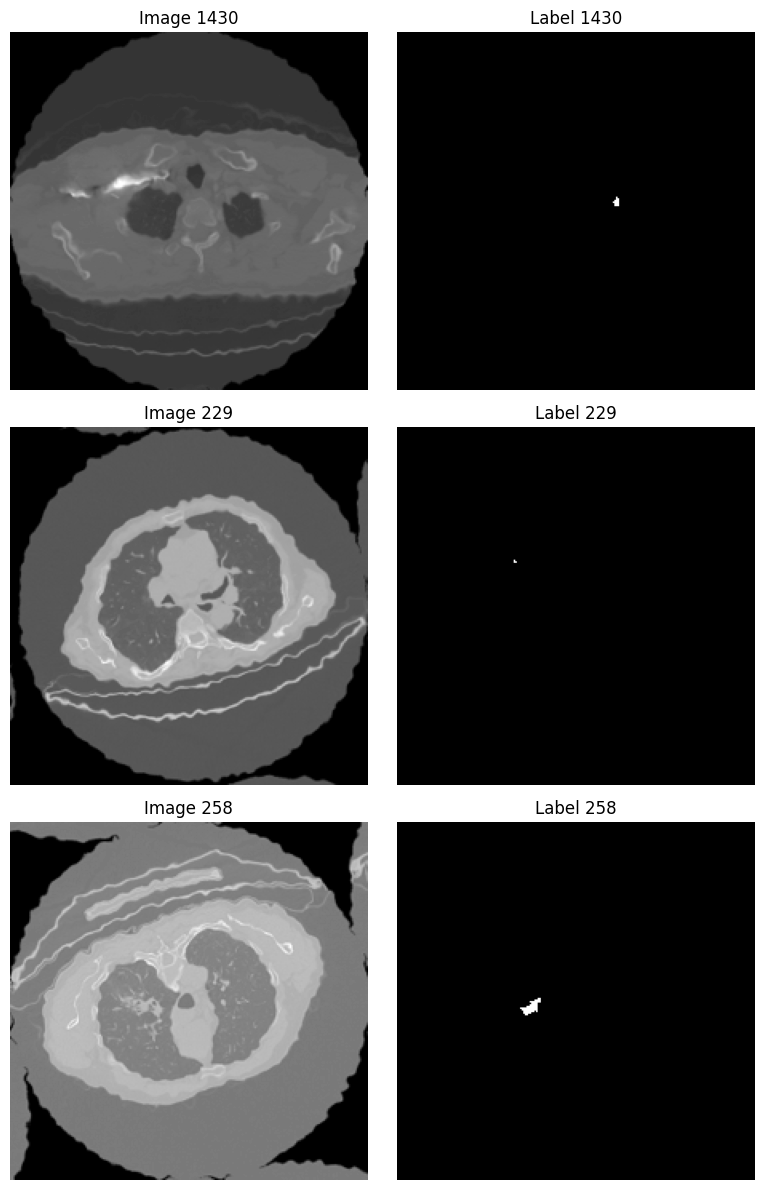

In [ ]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(3, 2, figsize=(8, 4 * 3))
for i in range(3):
        # Randomly select an index
    idx = 1 + i
    sample = train[idx]
    image = sample['image'].squeeze(0)
    label = sample['label'].squeeze(0)
    axes[i, 0].imshow(image, cmap='gray')
    axes[i, 0].set_title(f"Image {idx}")
    axes[i, 0].axis('off')
    axes[i, 1].imshow(label, cmap='gray')
    axes[i, 1].set_title(f"Label {idx}")
    axes[i, 1].axis('off')
    
plt.tight_layout()
plt.show()

## Swin-Unet Architecture

In [5]:
def window_partition(x, window_size):
    B, H, W, C = x.shape
    x = x.view(B, H // window_size[0], window_size[0], W // window_size[1], window_size[1], C)
    windows = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(-1, window_size[0], window_size[1], C)
    return windows

def window_reverse(windows, window_size, H, W):
    C = windows.shape[-1]
    x = windows.view(-1, H // window_size[0], W // window_size[1], window_size[0], window_size[1], C)
    x = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(-1, H, W, C)
    return x

def get_relative_position_index(win_h: int, win_w: int):
    # get pair-wise relative position index for each token inside the window
    coords = torch.stack(torch.meshgrid(torch.arange(win_h), torch.arange(win_w),indexing='ij'))  # 2, Wh, Ww
    coords_flatten = torch.flatten(coords, 1)  # 2, Wh*Ww
    relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]  # 2, Wh*Ww, Wh*Ww
    relative_coords = relative_coords.permute(1, 2, 0).contiguous()  # Wh*Ww, Wh*Ww, 2
    relative_coords[:, :, 0] += win_h - 1  # shift to start from 0
    relative_coords[:, :, 1] += win_w - 1
    relative_coords[:, :, 0] *= 2 * win_w - 1
    return relative_coords.sum(-1)  # Wh*Ww, Wh*Ww

class WindowAttention(nn.Module):
    def __init__(
            self,
            dim,
            window_size,
    ):
        super().__init__()
        self.window_size = window_size
        self.window_area = self.window_size[0]*self.window_size[1]
        self.num_heads = 4
        head_dim =  dim // self.num_heads
        # attn_dim = head_dim * self.num_heads
        self.scale = head_dim ** -0.5

        self.relative_position_bias_table = nn.Parameter(torch.zeros((2 * window_size[0] - 1) **2, self.num_heads))

        # get pair-wise relative position index for each token inside the window
        self.register_buffer("relative_position_index", get_relative_position_index(self.window_size[0], self.window_size[1]), persistent=False)

        self.qkv = nn.Linear(dim, dim * 3)
        self.proj = nn.Linear(dim, dim)

        torch.nn.init.trunc_normal_(self.relative_position_bias_table, std=.02)
        self.softmax = nn.Softmax(dim=-1)

    def _get_rel_pos_bias(self):
        relative_position_bias = self.relative_position_bias_table[
            self.relative_position_index.view(-1)].view(self.window_area, self.window_area, -1)  # Wh*Ww,Wh*Ww,nH
        relative_position_bias = relative_position_bias.permute(2, 0, 1).contiguous()  # nH, Wh*Ww, Wh*Ww
        return relative_position_bias.unsqueeze(0)

    def forward(self, x, mask = None):
        B_, N, C = x.shape
        qkv = self.qkv(x).reshape(B_, N, 3, self.num_heads, -1).permute(2, 0, 3, 1, 4)
        q, k, v = qkv.unbind(0)


        q = q * self.scale
        attn = q @ k.transpose(-2, -1)
        attn = attn + self._get_rel_pos_bias()
        if mask is not None:
            num_win = mask.shape[0]
            attn = attn.view(-1, num_win, self.num_heads, N, N) + mask.unsqueeze(1).unsqueeze(0)
            attn = attn.view(-1, self.num_heads, N, N)
        attn = self.softmax(attn)
        x = attn @ v

        x = x.transpose(1, 2).reshape(B_, N, -1)
        x = self.proj(x)
        return x

In [6]:
class SwinTransformerBlock(nn.Module):
    def __init__(
            self,  dim, input_resolution, window_size = 7, shift_size = 0):

        super().__init__()
        self.input_resolution = input_resolution
        window_size = (window_size, window_size)
        shift_size = (shift_size, shift_size)
        self.window_size = window_size
        self.shift_size = shift_size
        self.window_area = self.window_size[0] * self.window_size[1]

        self.norm1 = nn.LayerNorm(dim)
        self.attn = WindowAttention(
            dim,
            window_size=self.window_size,
        )

        self.norm2 = nn.LayerNorm(dim)

        self.mlp = nn.Sequential(
            nn.Linear(dim, 4 * dim),
            nn.GELU(),
            nn.LayerNorm(4 * dim),
            nn.Linear( 4 * dim, dim)
        )

        if self.shift_size:
            # calculate attention mask for SW-MSA
            H, W = self.input_resolution
            H = math.ceil(H / self.window_size[0]) * self.window_size[0]
            W = math.ceil(W / self.window_size[1]) * self.window_size[1]
            img_mask = torch.zeros((1, H, W, 1))  # 1 H W 1
            cnt = 0
            for h in (
                    slice(0, -self.window_size[0]),
                    slice(-self.window_size[0], -self.shift_size[0]),
                    slice(-self.shift_size[0], None)):
                for w in (
                        slice(0, -self.window_size[1]),
                        slice(-self.window_size[1], -self.shift_size[1]),
                        slice(-self.shift_size[1], None)):
                    img_mask[:, h, w, :] = cnt
                    cnt += 1
            mask_windows = window_partition(img_mask, self.window_size)  # nW, window_size, window_size, 1
            mask_windows = mask_windows.view(-1, self.window_area)
            attn_mask = mask_windows.unsqueeze(1) - mask_windows.unsqueeze(2)
            attn_mask = attn_mask.masked_fill(attn_mask != 0, float(-100.0)).masked_fill(attn_mask == 0, float(0.0))
        else:
            attn_mask = None

        self.register_buffer("attn_mask", attn_mask, persistent=False)

    def _attn(self, x):
        B, H, W, C = x.shape

        # cyclic shift
        if self.shift_size:
            shifted_x = torch.roll(x, shifts=(-self.shift_size[0], -self.shift_size[1]), dims=(1, 2))
        else:
            shifted_x = x

        # partition windows
        x_windows = window_partition(shifted_x, self.window_size)  # nW*B, window_size, window_size, C
        x_windows = x_windows.view(-1, self.window_area, C)  # nW*B, window_size*window_size, C

        # W-MSA/SW-MSA
        attn_windows = self.attn(x_windows, mask=self.attn_mask)  # nW*B, window_size*window_size, C

        # merge windows
        attn_windows = attn_windows.view(-1, self.window_size[0], self.window_size[1], C)
        shifted_x = window_reverse(attn_windows, self.window_size, H, W)  # B H' W' C
        shifted_x = shifted_x[:, :H, :W, :].contiguous()

        # reverse cyclic shift
        if self.shift_size:
            x = torch.roll(shifted_x, shifts=self.shift_size, dims=(1, 2))
        else:
            x = shifted_x
        return x

    def forward(self, x):
        B, H, W, C = x.shape
        B, H, W, C = x.shape
        x = x + self._attn(self.norm1(x))
        x = x.reshape(B, -1, C)
        x = x + self.mlp(self.norm2(x))
        x = x.reshape(B, H,W, C)
        return x


In [7]:
class PatchEmbedding(nn.Module):
    def __init__(self, in_ch, num_feat, patch_size):
        super().__init__()
        self.conv = nn.Conv2d(in_ch,num_feat, kernel_size=patch_size,
                                  stride=patch_size)

    def forward(self, X):
        # Output shape: (batch size, no. of patches, no. of channels)
        return self.conv(X).permute(0,2,3,1)

class PatchMerging(nn.Module):

    def __init__(
            self,
            dim
    ):
        super().__init__()
        self.norm = nn.LayerNorm(4 * dim)
        self.reduction = nn.Linear(4*dim, 2*dim, bias=False)

    def forward(self, x):
        B, H, W, C = x.shape
        x = x.reshape(B, H // 2, 2, W // 2, 2, C).permute(0, 1, 3, 4, 2, 5).flatten(3)
        x = self.norm(x)
        x = self.reduction(x)
        return x

class PatchExpansion(nn.Module):

    def __init__(
            self,
            dim
    ):
        super().__init__()
        self.norm = nn.LayerNorm(dim//2)
        self.expand = nn.Linear(dim, 2*dim, bias=False)

    def forward(self, x):

        x = self.expand(x)
        B, H, W, C = x.shape

        x = x.view(B, H , W, 2, 2, C//4)
        x = x.permute(0,1,3,2,4,5)

        x = x.reshape(B,H*2, W*2 , C//4)

        x = self.norm(x)
        return x

class FinalPatchExpansion(nn.Module):

    def __init__(
            self,
            dim
    ):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.expand = nn.Linear(dim, 16*dim, bias=False)

    def forward(self, x):

        x = self.expand(x)
        B, H, W, C = x.shape

        x = x.view(B, H , W, 4, 4, C//16)
        x = x.permute(0,1,3,2,4,5)

        x = x.reshape(B,H*4, W*4 , C//16)

        x = self.norm(x)
        return x

In [8]:
class SwinBlock(nn.Module):
    def __init__(self, dims, ip_res, ss_size = 3):
        super().__init__()
        self.swtb1 = SwinTransformerBlock(dim=dims, input_resolution=ip_res)
        self.swtb2 = SwinTransformerBlock(dim=dims, input_resolution=ip_res, shift_size=ss_size)

    def forward(self, x):
        return self.swtb2(self.swtb1(x))


class Encoder(nn.Module):
    def __init__(self, C, partioned_ip_res, num_blocks=3):
        super().__init__()
        H,W = partioned_ip_res[0], partioned_ip_res[1]
        self.enc_swin_blocks = nn.ModuleList([
            SwinBlock(C, (H, W)),
            SwinBlock(2*C, (H//2, W//2)),
            SwinBlock(4*C, (H//4, W//4))
        ])
        self.enc_patch_merge_blocks = nn.ModuleList([
            PatchMerging(C),
            PatchMerging(2*C),
            PatchMerging(4*C)
        ])

    def forward(self, x):
        skip_conn_ftrs = []
        for swin_block,patch_merger in zip(self.enc_swin_blocks, self.enc_patch_merge_blocks):
            x = swin_block(x)
            skip_conn_ftrs.append(x)
            x = patch_merger(x)
        return x, skip_conn_ftrs


class Decoder(nn.Module):
    def __init__(self, C, partioned_ip_res, num_blocks=3):
        super().__init__()
        H,W = partioned_ip_res[0], partioned_ip_res[1]
        self.dec_swin_blocks = nn.ModuleList([
            SwinBlock(4*C, (H//4, W//4)),
            SwinBlock(2*C, (H//2, W//2)),
            SwinBlock(C, (H, W))
        ])
        self.dec_patch_expand_blocks = nn.ModuleList([
            PatchExpansion(8*C),
            PatchExpansion(4*C),
            PatchExpansion(2*C)
        ])
        self.skip_conn_concat = nn.ModuleList([
            nn.Linear(8*C, 4*C),
            nn.Linear(4*C, 2*C),
            nn.Linear(2*C, 1*C)
        ])

    def forward(self, x, encoder_features):
        for patch_expand,swin_block, enc_ftr, linear_concatter in zip(self.dec_patch_expand_blocks, self.dec_swin_blocks, encoder_features,self.skip_conn_concat):
            x = patch_expand(x)
            x = torch.cat([x, enc_ftr], dim=-1)
            x = linear_concatter(x)
            x = swin_block(x)
        return x


class SwinUNet(nn.Module):
    def __init__(self, H, W, ch, C, num_class, num_blocks=3, patch_size = 4):
        super().__init__()
        self.patch_embed = PatchEmbedding(ch, C, patch_size)
        self.encoder = Encoder(C, (H//patch_size, W//patch_size),num_blocks)
        self.bottleneck = SwinBlock(C*(2**num_blocks), (H//(patch_size* (2**num_blocks)), W//(patch_size* (2**num_blocks))))
        self.decoder = Decoder(C, (H//patch_size, W//patch_size),num_blocks)
        self.final_expansion = FinalPatchExpansion(C)
        self.head        = nn.Conv2d(C, num_class, 1,padding='same')

    def forward(self, x):
        x = self.patch_embed(x)

        x,skip_ftrs  = self.encoder(x)

        x = self.bottleneck(x)

        x = self.decoder(x, skip_ftrs[::-1])

        x = self.final_expansion(x)

        x = self.head(x.permute(0,3,1,2))

        return x


## Model training

In [ ]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

loss_fn = nn.BCEWithLogitsLoss()

def train_epoch(model, dataloader):
    model.train()
    losses = []
    for batch in tqdm(dataloader, desc="Training", leave=False):
        optimizer.zero_grad()
        out = model(batch["image"].to(DEVICE))  
        target = batch["label"].unsqueeze(1).to(DEVICE).float()  
        loss = loss_fn(out, target)  
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    return np.mean(losses)

def validate_epoch(model, dataloader):
    model.eval()
    losses = []
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Validation", leave=False):
            out = model(batch["image"].to(DEVICE))
            target = batch["label"].unsqueeze(1).to(DEVICE).float()  
            loss = loss_fn(out, target)  
            losses.append(loss.item())
    return np.mean(losses)
    

def train_on_unagumented(model, dataloader):
    model.train()
    losses = []
    for batch in tqdm(dataloader, desc="Validation", leave=False):
        optimizer.zero_grad()
        out = model(batch["image"].to(DEVICE))
        target = batch["label"].unsqueeze(1).to(DEVICE).float() 
        loss = loss_fn(out, target)  
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    losses.append(loss.item())
    return losses
def train(model, epochs, min_epochs, early_stop_count):
    best_valid_loss = float('inf')
    EARLY_STOP = early_stop_count 
    
    for ep in range(epochs):
        print(f"Epoch {ep + 1}/{epochs}")
        train_loss = train_epoch(model, train_loader)
        train_non = train_on_unagumented(model,train_non_loader)
        valid_loss = validate_epoch(model, test_loader)
        print(f'Epoch: {ep + 1}: train_loss={train_loss:.5f}, valid_loss={np.mean(valid_loss):.5f}')
        if np.mean(valid_loss) < best_valid_loss:
            best_valid_loss = np.mean(valid_loss)
            torch.save(model.state_dict(), "best_model_dice.pth")
            print("Best model saved!")
            if ep >= min_epochs:
                EARLY_STOP = early_stop_count 

        if ep >= min_epochs:
            if np.mean(valid_loss) >= best_valid_loss:
                EARLY_STOP -= 1
                print(f"Early stopping counter: {EARLY_STOP}/{early_stop_count}")
                if EARLY_STOP <= 0:
                    print("Early stopping triggered.")
                    return train_loss, valid_loss
            else:
                pass

    return train_loss, valid_loss

In [11]:
class DiceLoss(nn.Module):
    def __init__(self, n_classes):
        super(DiceLoss, self).__init__()
        self.n_classes = n_classes

    def _one_hot_encoder(self, input_tensor):
        tensor_list = []
        for i in range(self.n_classes):
            temp_prob = input_tensor == i  # * torch.ones_like(input_tensor)
            tensor_list.append(temp_prob.unsqueeze(1))
        output_tensor = torch.cat(tensor_list, dim=1)
        return output_tensor.float()

    def _dice_loss(self, score, target):
        target = target.float()
        smooth = 1e-5
        intersect = torch.sum(score * target)
        y_sum = torch.sum(target * target)
        z_sum = torch.sum(score * score)
        loss = (2 * intersect + smooth) / (z_sum + y_sum + smooth)
        loss = 1 - loss
        return loss

    def forward(self, inputs, target, weight=None, softmax=False):
        if softmax:
            inputs = torch.softmax(inputs, dim=1)
        target = self._one_hot_encoder(target)
        if weight is None:
            weight = [1] * self.n_classes
        assert inputs.size() == target.size(), 'predict {} & target {} shape do not match'.format(inputs.size(), target.size())
        class_wise_dice = []
        loss = 0.0
        for i in range(0, self.n_classes):
            dice = self._dice_loss(inputs[:, i], target[:, i])
            class_wise_dice.append(1.0 - dice.item())
            loss += dice * weight[i]
        return loss / self.n_classes

In [12]:
# Define the device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the model and move it to the appropriate device
model = SwinUNet(224, 224, 1, 32, 1, 3, 4).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(),lr = 0.00025)
loss_fn = nn.BCEWithLogitsLoss()
#loss_fn = DiceLoss(n_classes = 1)
# Load the pre-trained weights
# train(model, 150, 100, 10)
# Apply the state dictionary to the model
# checkpoint_path = "/kaggle/input/lung-swin/pytorch/default/1/best_model (1).pth"
# checkpoint = torch.load(checkpoint_path, map_location=DEVICE)  # Load the checkpoi
# model.load_state_dict(checkpoint)

# Visualizing results

In [13]:
checkpoint_path = "/kaggle/input/lung-swin/pytorch/default/3/best_model_dice.pth"
checkpoint = torch.load(checkpoint_path, map_location=DEVICE)  
model.load_state_dict(checkpoint)

<ipython-input-13-c7aeaefd463e>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=DEVICE)


<All keys matched successfully>

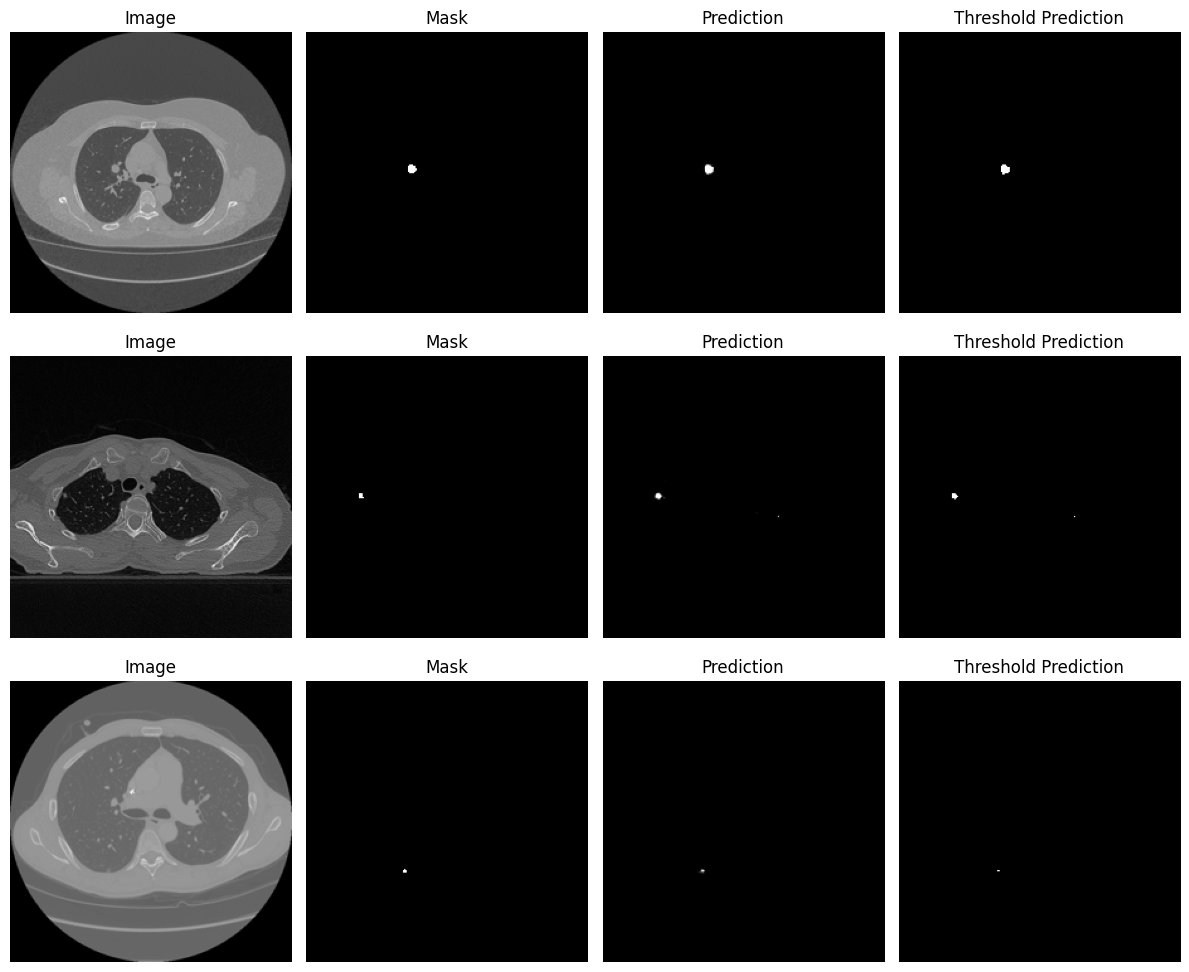

In [ ]:
import matplotlib.pyplot as plt
import torch.nn as nn

# Create a figure with subplots
fig, ax = plt.subplots(3, 4, figsize=(12, 10)) 

with torch.no_grad():
    for i in range(3): 
        batch = next(iter(test_loader))
        x = batch["image"][0].cpu() 
        y = batch["label"][0].cpu()  

        ax[i, 0].imshow(x.squeeze(0).squeeze(0), cmap='gray')
        ax[i, 0].set_title('Image')
        ax[i, 0].axis('off')  
        ax[i, 1].imshow(y.squeeze(0).squeeze(0), cmap='gray')  
        ax[i, 1].set_title('Mask')
        ax[i, 1].axis('off')  

        x_og = x.unsqueeze(0).to(DEVICE)  
        out = model(x_og)  
        out = nn.Sigmoid()(out)  
        out = out.squeeze(0).squeeze(0).cpu()
        ax[i, 2].imshow(out, cmap='gray')
        ax[i, 2].set_title('Prediction')
        ax[i, 2].axis('off')  
        thresholded_out = (out > 0.5).float() 
        ax[i, 3].imshow(thresholded_out, cmap='gray')
        ax[i, 3].set_title('Threshold Prediction')
        ax[i, 3].axis('off') 
plt.tight_layout()
plt.show()

In [15]:
def save_inference_results(image, mask, pred_mask, save_dir, sample_idx):
    image = image.squeeze().cpu().numpy()
    pred_mask = pred_mask.cpu().numpy()
    if image.ndim == 3:
        image = image[0]
    if pred_mask.ndim != 2:
        pred_mask = pred_mask.squeeze()
    image = (image - image.min()) / (image.max() - image.min() + 1e-8) * 255
    image = image.astype(np.uint8)
    pred_mask = (pred_mask > 0).astype(np.uint8) * 255
    original_dir = os.path.join(save_dir, "original_images")
    predicted_dir = os.path.join(save_dir, "predicted_masks")
    os.makedirs(original_dir, exist_ok=True)
    os.makedirs(predicted_dir, exist_ok=True)
    original_path = os.path.join(original_dir, f"sample_{sample_idx}_original.png")
    predicted_path = os.path.join(predicted_dir, f"sample_{sample_idx}_predicted.png")
    Image.fromarray(image).save(original_path)
    Image.fromarray(pred_mask).save(predicted_path)

In [16]:
import torch
import numpy as np
from PIL import Image
import os

def compute_rmse(y_pred, y_true):
    y_pred = y_pred.float()
    y_true = y_true.float()
    mse = torch.mean((y_pred - y_true) ** 2)
    rmse = torch.sqrt(mse)
    return rmse.item()

def compute_dice_coefficient(y_pred, y_true, threshold=0.5):
    y_pred = (y_pred > threshold).float()
    y_pred = y_pred.view(-1)
    y_true = y_true.view(-1)
    intersection = torch.sum(y_pred * y_true)
    dice = (2. * intersection) / (torch.sum(y_pred) + torch.sum(y_true) + 1e-8)
    return dice.item()

def compute_iou(y_pred, y_true, threshold=0.5):
    y_pred = (y_pred > threshold).float()
    y_pred = y_pred.view(-1)
    y_true = y_true.view(-1)
    intersection = torch.sum(y_pred * y_true)
    union = torch.sum(y_pred) + torch.sum(y_true) - intersection
    iou = intersection / (union + 1e-8)
    return iou.item()

def compute_precision_recall_f1(y_pred, y_true, threshold=0.5):
    y_pred = (y_pred > threshold).float()
    y_pred = y_pred.view(-1)
    y_true = y_true.view(-1)
    tp = torch.sum(y_pred * y_true)
    fp = torch.sum(y_pred * (1 - y_true))
    fn = torch.sum((1 - y_pred) * y_true)
    precision = tp / (tp + fp + 1e-8)
    recall = tp / (tp + fn + 1e-8)
    f1_score = 2 * (precision * recall) / (precision + recall + 1e-8)
    return precision.item(), recall.item(), f1_score.item()

def evaluate_model(model, data_loader, device, save_dir="/kaggle/working/", num_samples_to_save=264):
    model.eval()
    total_rmse = 0.0
    total_dice = 0.0
    total_iou = 0.0
    total_precision = 0.0
    total_recall = 0.0
    total_f1 = 0.0
    num_samples = 0
    saved_samples = 0
    with torch.no_grad():
        for batch in data_loader:
            images = batch["image"].to(device)
            masks = batch["label"].to(device)
            outputs = model(images)
            outputs = torch.sigmoid(outputs)
            outputs = outputs.cpu()
            masks = masks.cpu()
            for idx, (image, mask, pred) in enumerate(zip(images, masks, outputs)):
                total_rmse += compute_rmse(pred, mask)
                total_dice += compute_dice_coefficient(pred, mask)
                total_iou += compute_iou(pred, mask)
                precision, recall, f1_score = compute_precision_recall_f1(pred, mask)
                total_precision += precision
                total_recall += recall
                total_f1 += f1_score
                if save_dir and saved_samples < num_samples_to_save:
                    save_inference_results(image, mask, (pred > 0.3).float(), save_dir, saved_samples)
                    saved_samples += 1
            num_samples += images.size(0)
    mean_rmse = total_rmse / num_samples
    mean_dice = total_dice / num_samples
    mean_iou = total_iou / num_samples
    mean_precision = total_precision / num_samples
    mean_recall = total_recall / num_samples
    mean_f1 = total_f1 / num_samples
    return {
        "RMSE": mean_rmse,
        "Dice": mean_dice,
        "IoU": mean_iou,
        "Precision": mean_precision,
        "Recall": mean_recall,
        "F1-Score": mean_f1
    }

In [ ]:
eval_results = evaluate_model(model, test_loader, DEVICE)

print(f"RMSE: {eval_results['RMSE']:.4f}")
print(f"Dice Coefficient: {eval_results['Dice']:.4f}")
print(f"IoU: {eval_results['IoU']:.4f}")

RMSE: 0.0119
Dice Coefficient: 0.7969
IoU: 0.7143


In [18]:
print(eval_results)

{'RMSE': 0.011930749650814176, 'Dice': 0.796920210737543, 'IoU': 0.7142892481432748, 'Precision': 0.8389748337957048, 'Recall': 0.7926554392600796, 'F1-Score': 0.7969202036710129}


In [19]:
import os

def find_jpg_files(directory):
    jpg_files = []
    for root, _, files in os.walk(directory): 
        for file in files:
            if file.lower().endswith(".png"):  
                jpg_files.append(os.path.join(root, file))  
    return jpg_files

directory_path = "/kaggle/working/original_images"
jpg_files = find_jpg_files(directory_path)
print(f"Found {len(jpg_files)} .jpg files:")
for file in jpg_files:
    print(file)

Found 97 .jpg files:
/kaggle/working/original_images/sample_88_original.png
/kaggle/working/original_images/sample_23_original.png
/kaggle/working/original_images/sample_75_original.png
/kaggle/working/original_images/sample_13_original.png
/kaggle/working/original_images/sample_58_original.png
/kaggle/working/original_images/sample_54_original.png
/kaggle/working/original_images/sample_66_original.png
/kaggle/working/original_images/sample_0_original.png
/kaggle/working/original_images/sample_62_original.png
/kaggle/working/original_images/sample_1_original.png
/kaggle/working/original_images/sample_90_original.png
/kaggle/working/original_images/sample_49_original.png
/kaggle/working/original_images/sample_29_original.png
/kaggle/working/original_images/sample_9_original.png
/kaggle/working/original_images/sample_22_original.png
/kaggle/working/original_images/sample_51_original.png
/kaggle/working/original_images/sample_7_original.png
/kaggle/working/original_images/sample_81_origin

In [ ]:
import os
from PIL import Image
import numpy as np
import torch

def save_inference_results_from_dataloader(data_loader, model, device, save_dir):
    original_dir = os.path.join(save_dir, "original_images")
    predicted_dir = os.path.join(save_dir, "predicted_masks")
    os.makedirs(original_dir, exist_ok=True)
    os.makedirs(predicted_dir, exist_ok=True)

    model.eval()
    saved_samples = 0

    with torch.no_grad():
        for batch in data_loader:
            images = batch["image"].to(device)
            outputs = model(images) if model else None
            outputs = torch.sigmoid(outputs).cpu() if model else None
            images = images.cpu()

            for image, pred in zip(images, outputs):
                image_np = image.squeeze().numpy()
                image_np = ((image_np - image_np.min()) / (image_np.max() - image_np.min() + 1e-8) * 255).astype(np.uint8)
                original_path = os.path.join(original_dir, f"sample_{saved_samples}_original.png")
                Image.fromarray(image_np).save(original_path)
                if model:
                    pred_mask_np = (pred > 0.5).squeeze().numpy() * 255
                    predicted_path = os.path.join(predicted_dir, f"sample_{saved_samples}_predicted.png")
                    Image.fromarray(pred_mask_np.astype(np.uint8)).save(predicted_path)
                print(f"Saved sample {saved_samples}")
                saved_samples += 1

if __name__ == "__main__":
    test_loader = torch.utils.data.DataLoader(test, batch_size=1, shuffle=True)
    swin_model = model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    save_directory = "/kaggle/working/"
    save_inference_results_from_dataloader(test_loader, swin_model, device, save_directory)

Saved sample 0
Saved sample 1
Saved sample 2
Saved sample 3
Saved sample 4
Saved sample 5
Saved sample 6
Saved sample 7
Saved sample 8
Saved sample 9
Saved sample 10
Saved sample 11
Saved sample 12
Saved sample 13
Saved sample 14
Saved sample 15
Saved sample 16
Saved sample 17
Saved sample 18
Saved sample 19
Saved sample 20
Saved sample 21
Saved sample 22
Saved sample 23
Saved sample 24
Saved sample 25
Saved sample 26
Saved sample 27
Saved sample 28
Saved sample 29
Saved sample 30
Saved sample 31
Saved sample 32
Saved sample 33
Saved sample 34
Saved sample 35
Saved sample 36
Saved sample 37
Saved sample 38
Saved sample 39
Saved sample 40
Saved sample 41
Saved sample 42
Saved sample 43
Saved sample 44
Saved sample 45
Saved sample 46
Saved sample 47
Saved sample 48
Saved sample 49
Saved sample 50
Saved sample 51
Saved sample 52
Saved sample 53
Saved sample 54
Saved sample 55
Saved sample 56
Saved sample 57
Saved sample 58
Saved sample 59
Saved sample 60
Saved sample 61
Saved sample 62
Sa